## Check GPU device

In [2]:
!nvidia-smi

Sat Apr  2 11:52:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install kaggle
!pip install tensorflow
!pip install transformers

     |████████████████████████████████| 462 kB 6.1 MB/s 
     |████████████████████████████████| 3.8 MB 17.2 MB/s 
     |████████████████████████████████| 67 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 45.2 MB/s 
     |████████████████████████████████| 895 kB 15.8 MB/s 
     |████████████████████████████████| 6.5 MB 42.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [9]:
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Copy the API command from kaggle
!kaggle datasets download -d datajameson/sentimentanalysisonmoviereviews
!unzip -q /content/sentimentanalysisonmoviereviews.zip -d data

sentimentanalysisonmoviereviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
import pandas as pd
df = pd.read_csv('data/train.tsv', sep="\t")

In [11]:
df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [12]:
df.drop_duplicates(subset="SentenceId", keep="first", inplace=True)

In [ ]:
## Check length for padding

In [13]:
len(df)

8529

## Check the length distribution of phrase

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


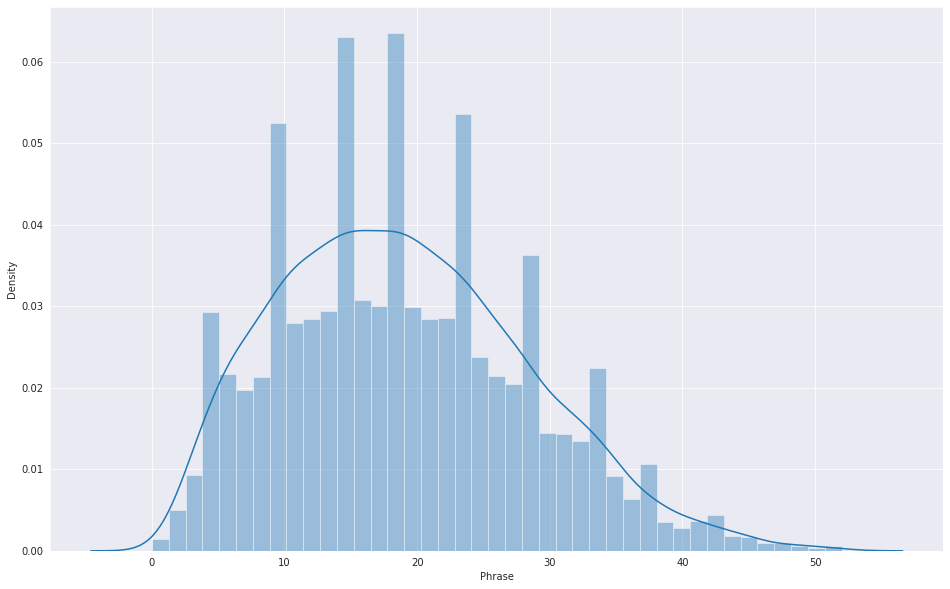

In [15]:
seq_len = df['Phrase'].apply(lambda x: len(x.split()))

sns.set_style('darkgrid')
plt.figure(figsize=(16, 10))
sns.distplot(seq_len)

In [16]:
SEQ_LEN = 50  # we will cut/pad our sequences to a length of 50 tokens

In [17]:
import numpy as np
from transformers import AutoTokenizer

In [18]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [20]:
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

In [21]:
# initialize two arrays for input tensors
Xids = np.zeros((len(df), SEQ_LEN))
Xmask = np.zeros((len(df), SEQ_LEN))

for i, sentence in enumerate(df['Phrase']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)
    if i % 10000 == 0:
        print(i)  # do this so we can see some progress

0


In [22]:
Xids

array([[ 101.,  138., 1326., ...,    0.,    0.,    0.],
       [ 101., 1188., 3589., ...,    0.,    0.,    0.],
       [ 101., 2431., 3899., ...,    0.,    0.,    0.],
       ...,
       [ 101.,  118.,  149., ...,    0.,    0.,    0.],
       [ 101., 1109., 2523., ...,    0.,    0.,    0.],
       [ 101., 1109., 1273., ...,    0.,    0.,    0.]])

In [23]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [24]:
arr = df['Sentiment'].values  # take sentiment column in df as array
labels = np.zeros((arr.size, arr.max()+1))  # initialize empty (all zero) label array
labels[np.arange(arr.size), arr] = 1  # add ones in indices where we have a value

In [25]:
df['Sentiment'].values

array([1, 4, 1, ..., 1, 1, 2])

In [26]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [27]:
import tensorflow as tf

BATCH_SIZE = 32  # we will use batches of 32

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# shuffle data and batch it
dataset = dataset.shuffle(100000).batch(BATCH_SIZE)

In [28]:
# get the length of the batched dataset
DS_LEN = len([0 for batch in dataset])
SPLIT = 0.9  # 90-10 split

train = dataset.take(round(DS_LEN*SPLIT))  # get first 90% of batches
val = dataset.skip(round(DS_LEN*SPLIT))  # skip first 90% and keep final 10%

del dataset  # optionally, delete dataset to free up disk-space

## Model definition
Our data is now ready and we can define our model architecture. We will use BERT, followed by an LSTM layer, and some simple NN layers. Those final layers following BERT are our classifier.

Our classifier consumes the output hidden state tensors from BERT — using them to predict whether we’re seeing something with positive or negative sentiment.

In [29]:
import tensorflow as tf
from transformers import AutoModel
from transformers import TFAutoModel

# initialize cased BERT model
bert = TFAutoModel.from_pretrained('bert-base-cased')

input_ids = tf.keras.layers.Input(shape=(50,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(50,), name='attention_mask', dtype='int32')

# we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.LSTM(64)(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(X)

# define input and output layers of our model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the BERT layer - otherwise we will be training 100M+ parameters...
model.layers[2].trainable = False

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                            

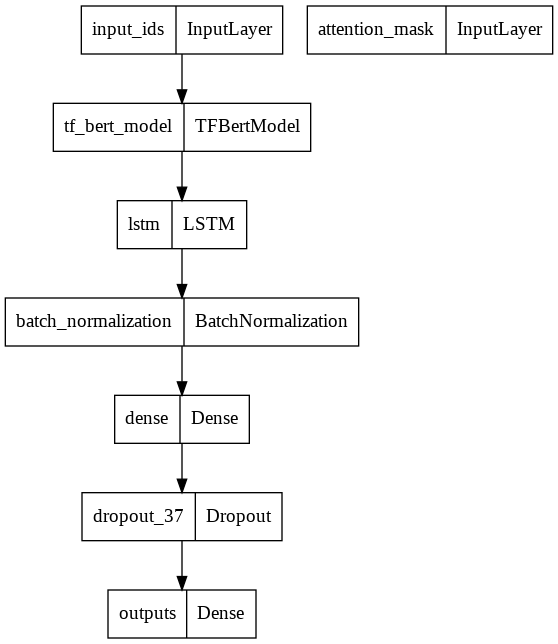

In [31]:

from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

## Training
First, we set up our optimizer (Adam), loss function, and accuracy metric. Then, we compile the model and train!

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.CategoricalCrossentropy()  # categorical = one-hot
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit(train, validation_data=val, epochs=120)

Epoch 1/120
240/240 [==============================] - 51s 143ms/step - loss: 1.4022 - accuracy: 0.3887 - val_loss: 1.4029 - val_accuracy: 0.3852
Epoch 2/120
 70/240 [=======>......................] - ETA: 20s - loss: 1.2996 - accuracy: 0.4295